Code for calculating velocity auto-correlation function $\xi_{vv,l}$
multipole in real space, using the module DDsmu

In [9]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DDsmu import DDsmu
from hankel import HankelTransform
from scipy.interpolate import InterpolatedUnivariateSpline as spline 
path ='/Users/ngoc/Desktop/Master-study/project'

In [10]:
#cosmological parameters
z        = 0.306                   #redshift
f        = 0.687255861             #growth rate
Omg_lamb = 0.685                   #dark energy density parameter
Omg_m    = 1. - Omg_lamb           #matter density parameter
a        = 1./(1. + z)             #scale factor
E_a      = np.sqrt(Omg_m*(1.+z)**3. + Omg_lamb) 


In [11]:
#simulation parameters
boxsize  = 2000                    #length of the box [Mpc/h]
nthreads = 4                       #number of Open MP threads to use 
autocorr = 1                       #auto correlation
nbins    = 50                      #number of bins
rmin     = 1.                      #minimum separation [Mpc/h]
rmax     = boxsize/3               #maximum separation [Mpc/h]
bins     = np.logspace(np.log10(rmin), np.log10(rmax), nbins+1)     
mu_max   = 1                       #maximum value of cosine of the angle separated from the LOS
nmu_bins = 10                      #number of bins of the angle separation 
delta_mu = mu_max/nmu_bins
ndata    = 8                       #number of data sets
set_data = "112345678"             #for reading data



In [12]:
A_0 = np.zeros((ndata,nbins))
r   = np.zeros((ndata,nbins))
A_2 = np.zeros((ndata,nbins))
A_4 = np.zeros((ndata,nbins))


#Legendre polynomials
P0 = 1
P2 = lambda mu: (3*mu**2-1)/2
P4 = lambda mu: (35*mu**4 - 30*mu**2 + 3)/8 


In [13]:
for i in range (0,ndata):
    # load positions of objects
    X = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (1))
    Y = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (2))
    Z = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (3))

    # load velocities of objects
    V_z     = np.loadtxt(path+'/catalogs/'+set_data[0]+set_data[i+1]+'/gals/2gpc/R1'+set_data[0]+set_data[i+1]+'_S014_clu_d.cat', usecols = (6))
    weights = V_z/(a*E_a*100)
    
    #calculate random-random pairs 
    N    = len(X)          # number of halos
    RR   = 4./3.*np.pi*(bins[1::]**3 - bins[0:-1:]**3)*N*(N-1)/boxsize**3
    
    # using DDsmu to calculate pair in each mu bin
    results_DDsmu = DDsmu(autocorr, 
                          nthreads,
                          bins,
                          mu_max,
                          nmu_bins,
                          X, Y, Z,
                          weights1    = weights,
                          boxsize     = boxsize,
                          weight_type = 'pair_product',
                          output_savg = True,
                          periodic    = True)
  
    npair         = results_DDsmu['npairs']
    weight        = results_DDsmu['weightavg']
#    mu            = results_DDsmu['mu_max']
    r_mu          = results_DDsmu['savg']
    DD_r_mu       = npair*weight
      
    #using mu value of F code
    mu    = np.loadtxt(path+'/my-f-code/results/xi-vv-realization'+set_data[i+1]+'.txt', usecols = (2))
        
    #monopole
    DD_r= np.zeros(nbins)      
    xi0 = np.zeros(nbins)
    r0  = np.zeros(nbins)
    l   = 0 
    for ii in range(0,nbins):
        for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
            xi0[ii] = xi0[ii] + DD_r_mu[j]/(RR[ii]/nmu_bins)*P0*delta_mu    
            r0[ii]  = r0[ii]  + r_mu[j]  
            DD_r[ii]= DD_r[ii]+ DD_r_mu[j]
    xi0 = (2*l+1)*xi0
    r0  = r0/nmu_bins
    
    A_0[i] = xi0
    r[i]   = r0
    
 
    #quadrupole
            
    xi2 = np.zeros(nbins)
    l   = 2
    
    for ii in range(0,nbins):
        for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
            xi2[ii] = xi2[ii] + DD_r_mu[j]/(RR[ii]/nmu_bins)*delta_mu*P2(mu[j])
   
    xi2    = (2*l+1)*xi2
    A_2[i] = xi2

  
    #hexadecapole
        
    xi4 = np.zeros(nbins)
    l   = 4    
    for ii in range(0,nbins):
        for j in range ((ii)*nmu_bins,(ii+1)*nmu_bins):
            xi4[ii] = xi4[ii] + DD_r_mu[j]/(RR[ii]/nmu_bins)*delta_mu*P4(mu[j])
        
    xi4    = (2*l+1)*xi4 
    A_4[i] = xi4
    


In [14]:
#calculate the mean values and error bars

#monopole
xi_vv0 = np.zeros(nbins)
r_simul  = np.zeros(nbins)

for i in range(0,nbins):
    r_simul[i]  = np.mean(r[0:ndata,i])
    xi_vv0[i]   = np.mean(A_0[0:ndata,i])

error_xi_vv0 = np.zeros(nbins) 
for i in range(0,nbins):
    a = 0
    for j in range(0,ndata):
        a = a + (A_0[j,i] - xi_vv0[i])**2.
#    error_xi_vv0[i] = np.sqrt(a/(ndata-1.))
    error_xi_vv0[i] = np.sqrt(a/(ndata*(ndata-1.)))

#quadrupole
xi_vv2 = np.zeros(nbins)
for i in range(0,nbins):
    xi_vv2[i] = np.mean(A_2[0:ndata,i])

error_xi_vv2 = np.zeros(nbins) 
for i in range(0,nbins):
    a = 0
    for j in range(0,ndata):
        a = a + (A_2[j,i] - xi_vv2[i])**2.
#    error_xi_vv2[i] = np.sqrt(a/(ndata-1.))
    error_xi_vv2[i] = np.sqrt(a/(ndata*(ndata-1.)))

In [6]:
# loading matter power spectrum

k   = np.loadtxt(path+'/my_results/matter_Pk.txt', usecols = (0))
P   = np.loadtxt(path+'/my_results/matter_Pk.txt', usecols = (1))
r   = np.loadtxt(path+'/my-p-code/xi_vv_realspace_mono.txt',usecols = (0))
P_k = spline(k, P)

Pcut = np.loadtxt(path+'/my-p-code/results/mPk_cut.txt',usecols=(1))
P_k_cut = spline(k,Pcut)

In [7]:
# xi_vv monopole
f1    = lambda kk: P_k(kk)/(kk*np.pi*2)**(3/2)
h10000    = HankelTransform(nu=1/2, N = np.pi*1e5, h = 1e-5)
xi_mono = 1/np.sqrt(r)*h10000.transform(f1,r, ret_err=False, inverse=True)  

f1_cut    = lambda kk: P_k_cut(kk)/(kk*np.pi*2)**(3/2)
xi_mono_cut = 1/np.sqrt(r)*h10000.transform(f1_cut,r, ret_err=False, inverse=True)  
    
xi_vv0_theory = f**2*xi_mono/3
xi_vv0_cut = f**2*xi_mono_cut/3

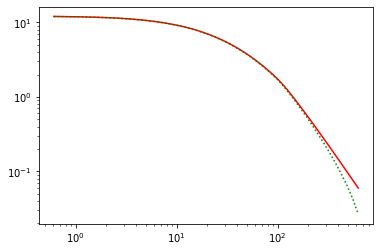

In [11]:
plt.loglog(r,xi_vv0_theory,'r-')
plt.loglog(r,xi_vv0_cut, 'g:')

In [13]:
# xi_vv quadrupole

h2    = HankelTransform(nu=5/2, N = 314150, h = 1e-5)

f1    = lambda kk: P_k(kk)/(kk*np.pi*2)**(3/2)
xi_p2 = 1/np.sqrt(r)*h2.transform(f1,r, ret_err=False, inverse=True)
xi_vv2_theory = -2/3*f**2*xi_p2


f1_cut    = lambda kk: P_k_cut(kk)/(kk*np.pi*2)**(3/2)
xi_p2_cut = 1/np.sqrt(r)*h2.transform(f1_cut,r, ret_err=False, inverse=True)
xi_vv2_cut = -2/3*f**2*xi_p2_cut



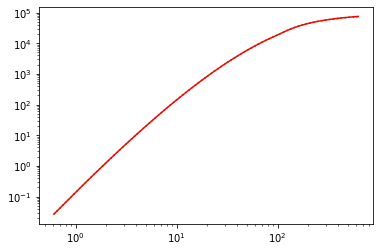

In [17]:
plt.loglog(r,-xi_vv2_cut*r**2,'g:')
plt.plot(r,-xi_vv2_theory*r**2,'r-')

(0.0, 2.0)

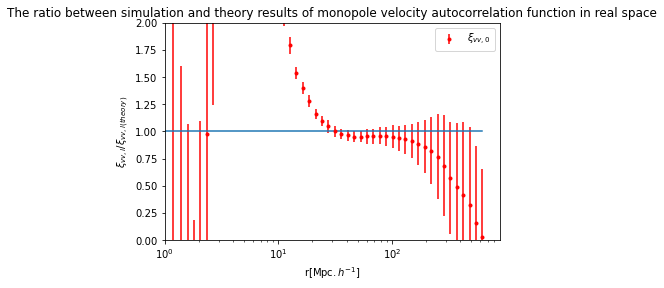

In [47]:
#ratio between simulation and linear theory results 
y = np.full_like(r_simul,1)
ax = plt.axes()
ax.set_xscale("log")
#ax.set_yscale("log")
ax.plot(r_simul,y)
ax.errorbar(r_simul,  xi_vv0/xi_vv0_theory, fmt = 'r.', yerr = error_xi_vv0*np.sqrt(8)/xi_vv0_theory, label ='$\\xi_{vv,0}$')
#ax.errorbar(r_simul,  xi_vv0/xi_vv0_theory, fmt = 'c.', yerr = (1+xi_vv0)/np.sqrt(DD_r)/xi_vv0_theory, label =' $\\xi_{vv,0}/\\xi_{vv,0 (Linear)}$ Poisson error')
ax.set_ylabel("$\\xi_{vv,l}/\\xi_{vv,l (theory)}$")
ax.set_xlabel("r[Mpc$.h^{-1}$]")
ax.set_title('The ratio between simulation and theory results of monopole velocity autocorrelation function in real space')
ax.legend()
ax.set_xlim(1,)
ax.set_ylim(0,2)
#plt.savefig('xi-vv0-Poisson-err.png')

<ipython-input-44-47b85a9b6a54>:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-1,200)


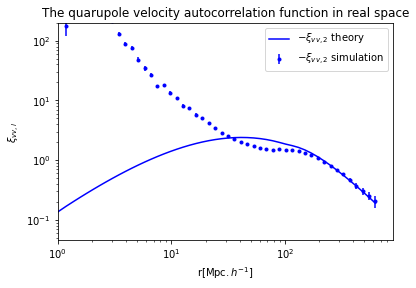

In [44]:
ax = plt.axes()
ax.set_xscale("log")
ax.set_yscale("log")
#for i in range(0,ndata):
#    ax.plot(r_simul,-A_2[i],':')
ax.errorbar(r_simul, -xi_vv2, fmt = 'b.', yerr = error_xi_vv2, label ='$-\\xi_{vv,2}$ simulation')
#ax.errorbar(r_simul, -xi_vv2, fmt = 'y.', yerr = (1+xi_vv2)/np.sqrt(DD_r), label ='$-\\xi_{vv,2}$ simulation Poisson error')
ax.plot(r_theory, -xi_vv2_theory, 'b-', label ='$-\\xi_{vv,2}$ theory')
ax.set_ylabel("$\\xi_{vv,l}$")
ax.set_xlabel("r[Mpc$.h^{-1}$]")
ax.set_title('The quarupole velocity autocorrelation function in real space')
ax.legend()
ax.set_xlim(1,)
ax.set_ylim(-1,200)
plt.savefig('xi_vv2.png')

(0.5, 1.5)

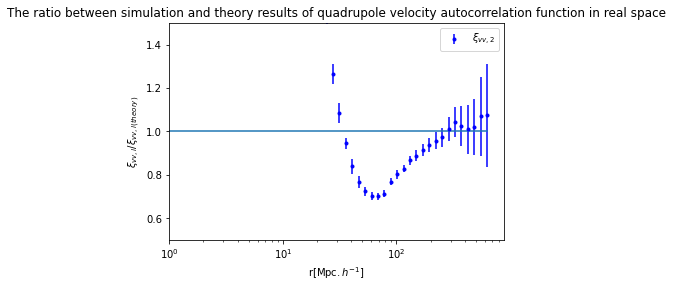

In [49]:
#ratio between simulation and linear theory results 
y = np.full_like(r_simul,1)
ax = plt.axes()
ax.set_xscale("log")
#ax.set_yscale("log")
ax.plot(r_simul,y)
ax.errorbar(r_simul,  xi_vv2/xi_vv2_theory, fmt = 'b.', yerr = error_xi_vv2/xi_vv2_theory,label='$\\xi_{vv,2}$')
#ax.errorbar(r_simul,  xi_vv2/xi_vv2_theory, fmt = 'y.', yerr = (1+xi_vv2)/np.sqrt(DD_r)/xi_vv2_theory, label ='$\\xi_{vv,2}\\xi_{vv,2(Linear)}$ Poisson error')
ax.set_ylabel("$\\xi_{vv,l}/\\xi_{vv,l (theory)}$")
ax.set_xlabel("r[Mpc$.h^{-1}$]")
ax.set_title('The ratio between simulation and theory results of quadrupole velocity autocorrelation function in real space')
ax.legend()
ax.set_xlim(1,)
ax.set_ylim(0.5,1.5)
#plt.savefig('xi-vv2-Poisson-err.png')